# Solver for the Maxwell-bloch equations w/ phase modulation.

***

## Equations:

Maxwell-bloch equation, after aproximations, with external phase modulation for $E_y$

$
\begin{cases}
\partial_{\tau} E_x=-k E_x + \mu P_x \\
\partial_{\tau} E_y=-k E_y + \mu P_y + i.(\Delta \phi_0 + m.cos(w_{mod}.\tau)).E_y \\
\partial_{\tau} P_{x,y}=-(1+i\delta)P_{x,y}+E_{x,y}.D \\
\partial_{\tau} D=-\gamma_{||}(D-D_0+\tfrac{1}{2}(E^*_{x,y}P_{x,y}+E_{x,y}P^*_{x,y})) \\
\end{cases}
$


with $ E_{x,y}$ and $P_{x,y}$  $\in \mathbb{C}$

##### Normalizations made: 
$\tau= \gamma_{\bot}.t$, $k=\tfrac{\bar{k}}{\gamma_{\bot}}$,  $\gamma_{\parallel}=\tfrac{\bar{\gamma_{\parallel}}}{\gamma_{\bot}}$, $\eta=\tfrac{z}{L}$, $\delta'_{ac}=\tfrac{w_a-w_0}{\gamma_{\bot}}$


##### Aproximations: 

1-$k,\gamma_{\parallel}<<\gamma_{\bot}$   -- Homogenously broadened laser linewidth $ \nabla^2 E-\frac{1}{c^2}\partial_{t^2}E=\alpha \partial_{t^2}E$

2-Plane wave: $\nabla^2_{\bot}=0$

3-Two level medium

4-Slowly varying amplitud

5-Unidirectional field

6-Rotating wave approx $\partial_{t^2}<<\partial_t$

7-Single longitudinal mode

8-$g'->0$, $R_0->1$  -- Uniform field limit

9-$m$,$w_{mod}<<1$, $w_{mod}<<\gamma_{\bot}$  ..chequear..

In [178]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 24 17:05:30 2015

@author: Alexis
"""
import numpy as np
#import scipy as sc
#import matplotlib
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#from numpy import linspace
#import math
#from matplotlib.collections import LineCollection
from comparefase import comparembfase
from intmbfase import intmbfase as integ
from intfaserev import intfaserev as intrev
from intmbfase2 import intmbfase2 as integ2
from scipy.signal import argrelextrema

#import datetime as dt
from time import localtime
#import time, sys
#import mpld3

'''---- |2>
    ||
    || R21
    ||
   ---- |1>'''

plt.ion()
pi=np.pi #defino pi


### Parameters

In [179]:
'''parameters for normalization'''
a=2.
gperp=10**8. #gamma perpendicular, loss rate
scale=1*(10.**6)/gperp #scale to micro seconds
wscale=1000*gperp/(10.**6)#scale frequency to khz

'''parameters for the equation'''
k=0.9*10.**7/gperp #normalized loss rate
mu=.25*10**(-4) #g
Dphi0=0.0 #phase shift [-pi,pi]
d=1.0 #detuning
g=2.5*10.**4/gperp #*((2*pi)**2) #sigma parallel, normalized loss rate
D0=a*k/mu #Poblation
m=.049 #modulation amplitud [0,1]
wf=0.004743420#.001*2*pi #modulation frequency

'''parameters to compare with the results'''
w_res=np.sqrt(k*g*((D0*mu/k)-1.))*wscale #resonance frequency
at=D0*mu/k
w=np.sqrt(k*g*(a-1.)-(g*g*a*a)/4)*wscale #Relaxation oscilations frequency
wf_real=wf*wscale


In [181]:
%matplotlib inline

## Initial conditions, Integration and variables

In [182]:
'''initial conditions'''
intime=500.*1000*10**(-6)*gperp #integration time
jump=25.
numstep=int(intime/jump)

def  initial():
    initial=raw_input('Initial contitions: \n  Write "new" to use new defined initial conditions.  \n write "l" to use last result as initial condition. \n yinit: ')
    if initial=='new':
        '''User defined initial condition'''
        timeinit = np.linspace(0., intime, numstep)
        dfxinit=[1., 1.] 
        dfyinit=[-2.,  -1.9]  
        drxinit=[-3.,   1.]
        dryinit=[-9.34720367e+02 ,  7.31585718e+02]
        ddeltainit=[6.65973518e+03]
        yinit=np.array(dfxinit+dfyinit+drxinit+dryinit+ddeltainit)
    if initial=='l':
        '''initial condition from last simulation'''
        timeinit = np.arange(time[-1] ,intime+time[-1] , 25.)
        yinit=y[-1]
    if initial=='':
        '''reuse last initial condition '''
    return yinit, timeinit

yinit, time=initial()
yinit1=np.copy(yinit)
yinit1[0]=yinit1[0]+yinit1[0]*200*np.finfo(float).eps
print '%.28e' %yinit[0], '%.28e' %yinit1[0]

Initial contitions: 
  Write "new" to use new defined initial conditions.  
 write "l" to use last result as initial condition. 
 yinit: l
7.2209191016758124860409388108e-274 7.2209191016761336660456404087e-274


In [183]:
'''integration'''
y, time=integ(yinit,time,k,mu,Dphi0,d,g,D0,m,wf)
print 'Last result to use as new initial condition: \n', 'dfxinit=[%e, %e] \n dfyinit=[%e,  %e] \n drxinit=[%e, %e] \n dryinit=[%e,  %e] \n  ddeltainit=[%e] ' %(y[-1][0], y[-1][1], y[-1][2], y[-1][3], y[-1][4], y[-1][5], y[-1][6], y[-1][7], y[-1][8])


Last result to use as new initial condition: 
dfxinit=[4.830651e-315, 2.242132e-315] 
 dfyinit=[-1.180662e-01,  5.073287e-02] 
 drxinit=[2.514353e-311, -7.959630e-312] 
 dryinit=[-2.787207e+02,  5.835740e+02] 
  ddeltainit=[6.722011e+03] 


In [184]:
np.shape(y)


(2000000L, 9L)

In [185]:
'''intensitys'''
intensity_ex=np.sqrt(y[:,0]**2+y[:,1]**2)
intensity_ey=np.sqrt(y[:,2]**2+y[:,3]**2)
intensity=np.sqrt(y[:,0]**2+y[:,1]**2+y[:,2]**2+y[:,3]**2)

peak_max=list(set(intensity[argrelextrema(intensity, np.greater)[0]]))#intensity peaks
w_peaks=list(wf*wscale*np.ones_like(peak_max))#vector or m, the same lenght as peak_max

## Plots

In [227]:
'''plots'''
save=False #set True if i want to save files automatically


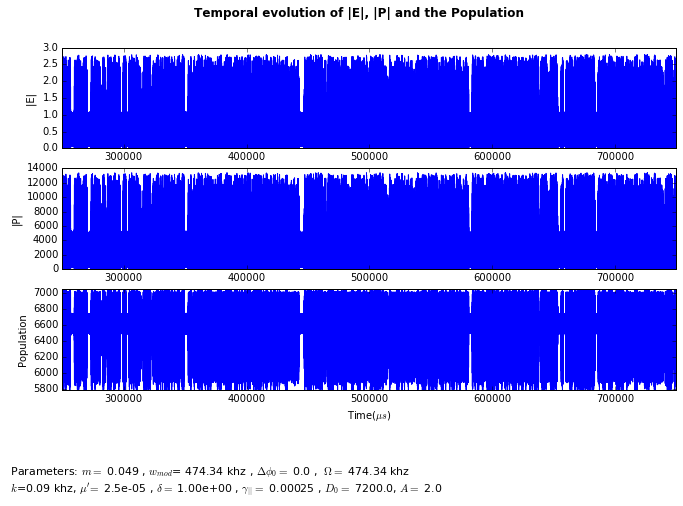

In [220]:

fig0=plt.figure()
fig0.suptitle('Temporal evolution of |E|, |P| and the Population', fontsize=12, fontweight='bold')
ax1 = fig0.add_subplot(3, 1, 1)
ax1.plot(time*scale,intensity)
ax1.set_ylabel('|E| ')
ax1.set_xlim(min(time*scale), max(time*scale))
ax2 = fig0.add_subplot(3, 1, 2)
ax2.set_xlim(min(time*scale), max(time*scale))
ax2.plot(time*scale,np.sqrt(y[:,4]**2+y[:,5]**2+y[:,6]**2+y[:,7]**2))
ax2.set_ylabel('|P|')
ax3 = fig0.add_subplot(3, 1, 3)
ax3.plot(time*scale,y[:,8])
plt.ylim(min(y[:,8]), max(y[:,8]))
ax3.set_ylabel('Population')
ax3.set_xlim(min(time*scale), max(time*scale))
plt.xlabel('Time($\mu s$)')
plt.text(-0.09,-1.05, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig0.set_size_inches(11, 7)

if save==True: 
    fname='%d_%d_%d-%d.%d.%d-Time_series.png' % localtime()[0:6]
    fig0.savefig(fname) 

#mpld3.display(fig0)



fig4=plt.figure()
periods=10
fig4.suptitle('Comparison between |E| and the Modulation', fontsize=12, fontweight='bold')
ax1 = fig4.add_subplot(3, 1, 1)
ax1.plot(time*scale,np.cos(wf*time), label='$w_{mod}$=%.2f khz' %wf_real)
ax1.set_xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
ax1.set_ylabel('Modulation ')
ax1.legend(fontsize = 'small')
ax2 = fig4.add_subplot(3, 1, 2)
ax2.plot(time*scale,intensity,label='First %i periods' %periods)
ax2.set_ylabel('|E|')
ax2.set_xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
ax2.legend(fontsize = 'small')
ax3 = fig4.add_subplot(3, 1, 3)
ax3.set_xlim(max(time*scale)-(periods*2*pi/wf)*scale, max(time*scale),emit='True')
ax3.plot(time*scale,intensity,label='Last %i periods' %periods)
ax3.set_ylim(intensity[len(intensity)-1]-8*(max(intensity[len(intensity)-9000:])-intensity[len(intensity)-1]),intensity[len(intensity)-1]+8*(max(intensity[len(intensity)-9000:])-intensity[len(intensity)-1]))
ax3.set_ylabel('|E|')
ax3.legend(fontsize = 'small')
plt.text(-0.09,-1.06, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig4.set_size_inches(8, 6)
plt.xlabel('Time ($\mu s$)')
#ax3.relim(visible_only=True)
#ax3.autoscale_view(tight=True, scalex=True, scaley=True)
#ax3.yaxis.zoom(3)
#ax3.yaxis.set_smart_bounds('True')
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-comparison periods.png' % localtime()[0:6]
    fig4.savefig(fname, dpi = 100)# when saving, specify the DPI

j=0 #LONGITUD EN INDICES DE 10 PERIODOS
print len(time)
for i in range(len(time)):
    while time[i]*scale < min(time*scale)+(periods*2*pi/wf)*scale:
        j=i
print j

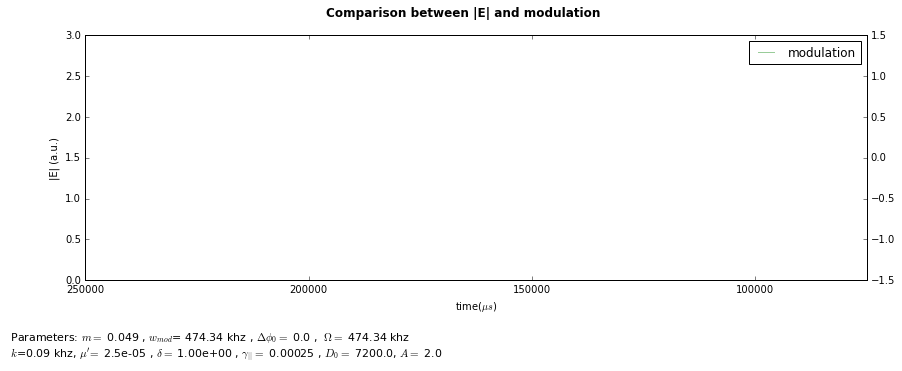

In [221]:

fig5=plt.figure()
fig5.suptitle('Comparison between |E| and modulation', fontsize=12, fontweight='bold')
ax1 = fig5.add_subplot(111)
ax1.plot(time*scale,intensity,'b', label='|E|')
ax2=ax1.twinx()
ax2.plot(time*scale,np.cos(wf*time),'g', alpha=0.4, label='modulation')
plt.xlim(min(time*scale),max(time*scale)*0.1)
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('|E| (a.u.)')
ax2.set_ylim(-1.5, 1.5)
#ax2.set_ylim(-intensity[len(intensity)-1, intensity[len(intensity)-1 )
plt.text(-0.1,-0.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig5.set_size_inches(14, 5)
plt.legend()
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-comparison.png' % localtime()[0:6]
    fig5.savefig(fname, dpi = 100)# when saving, specify the DPI

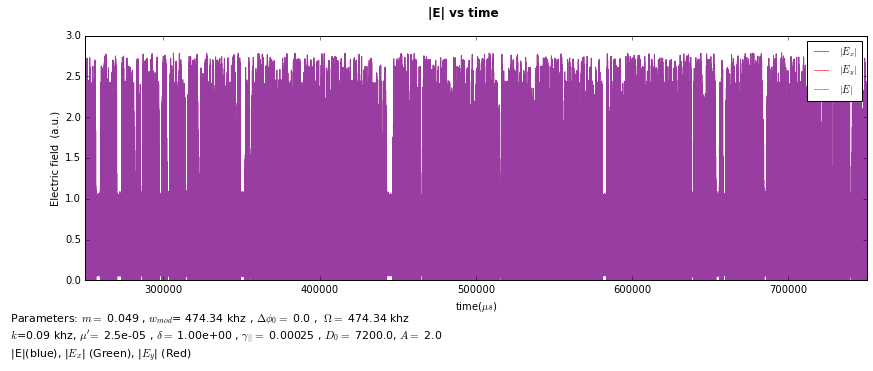

In [222]:
fig3=plt.figure()
fig3.suptitle('|E| vs time', fontsize=12, fontweight='bold')
ax1 = fig3.add_subplot(111)
plt.plot(time*scale,intensity_ex,'g', alpha=0.7,  label='$|E_x|$')
plt.plot(time*scale,intensity_ey,'r', alpha=0.6,  label='$|E_y|$')
plt.plot(time*scale,intensity,'b', alpha=0.4, label='$|E|$')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('Electric field  (a.u.)')
plt.xlim(min(time*scale), max(time*scale))
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), |$E_x$| (Green), |$E_y$| (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig3.set_size_inches(14, 5)

if save==True: 
    fname='%d_%d_%d-%d.%d.%d-E_intensitys.png' % localtime()[0:6]
    fig3.savefig(fname, dpi = 100)# when saving, specify the DPI


'''Phase spaces'''
fig8=plt.figure()
fig8.suptitle('|P| vs population', fontsize=12, fontweight='bold')
ax2 = fig8.add_subplot(111)
plt.plot(y[:,8], np.sqrt(y[:,4]**2+y[:,5]**2+y[:,6]**2+y[:,7]**2))
ax2.set_xlabel('Population')
ax2.set_ylabel('|P|')
plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig8.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-p_vs_population.png' % localtime()[0:6]
    fig8.savefig(fname) 

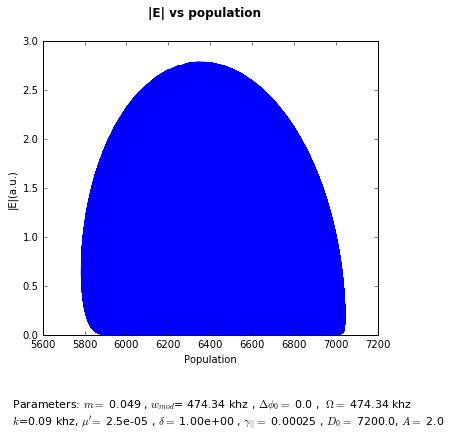

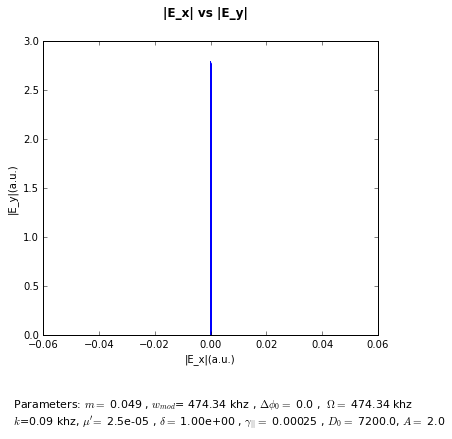

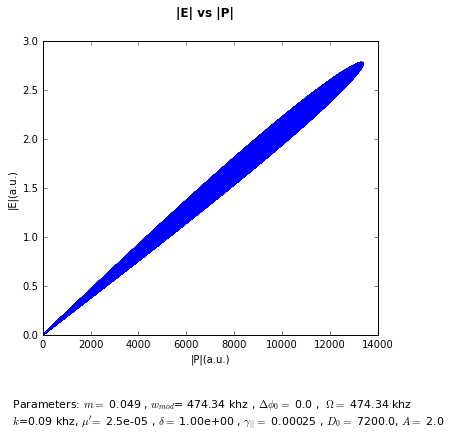

In [223]:
fig9=plt.figure()
fig9.suptitle('|E| vs population', fontsize=12, fontweight='bold')
ax2 = fig9.add_subplot(111)
plt.plot(y[:,8], intensity)
ax2.set_xlabel('Population')
ax2.set_ylabel('|E|(a.u.)')
plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig9.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-E_vs_population.png' % localtime()[0:6]
    fig9.savefig(fname, dpi = 120)# when saving, specify the DPI
    
fig9=plt.figure()
fig9.suptitle('|E_x| vs |E_y|', fontsize=12, fontweight='bold')
ax2 = fig9.add_subplot(111)
plt.plot(intensity_ex, intensity_ey)
ax2.set_xlabel('|E_x|(a.u.)')
ax2.set_ylabel('|E_y|(a.u.)')
plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig9.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-Ex_vs_Ey.png' % localtime()[0:6]
    fig9.savefig(fname, dpi = 120)# when saving, specify the DPI
    
fig9=plt.figure()
fig9.suptitle('|E| vs |P|', fontsize=12, fontweight='bold')
ax2 = fig9.add_subplot(111)
plt.plot(np.sqrt(y[:,4]**2+y[:,5]**2+y[:,6]**2+y[:,7]**2), intensity)
ax2.set_xlabel('|P|(a.u.)')
ax2.set_ylabel('|E|(a.u.)')
plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig9.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-E_vs_P.png' % localtime()[0:6]
    fig9.savefig(fname, dpi = 120)# when saving, specify the DPI
 

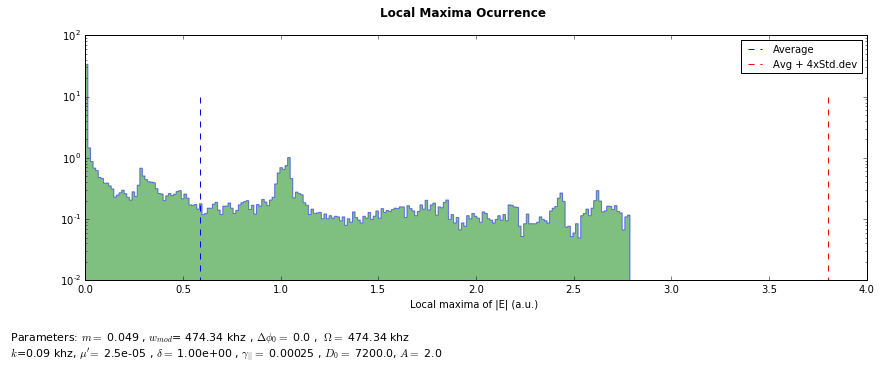

In [224]:
fig3=plt.figure()
fig3.suptitle('Local Maxima Ocurrence' , fontsize=12, fontweight='bold')
ax1 = fig3.add_subplot(111)
plt.hist(peak_max,210, histtype='step', facecolor='green', alpha=0.5, fill=True, normed=True)
#ax1.set_xlim(0.3,2.5)
ax1.set_xlabel('Local maxima of |E| (a.u.) ')
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig3.set_size_inches(14, 5)
plt.plot([np.mean(peak_max),np.mean(peak_max)],[10,0],'--b',label='Average')
plt.plot([np.mean(peak_max)+4*np.std(peak_max),np.mean(peak_max)+4*np.std(peak_max)],[10,0],'--r',label='Avg + 4xStd.dev')
plt.legend(fontsize = 'medium')
plt.yscale('log')
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-hist_E_intensitys.png' % localtime()[0:6]
    fig3.savefig(fname, dpi = 100)# when saving, specify the DPI

fig1=plt.figure()
fig1.suptitle('|E| vs time', fontsize=12, fontweight='bold')
ax1 = fig1.add_subplot(111)
ax1.plot(time*scale,y[:,0],'g', label='$Re(E_x)$')
ax1.plot(time*scale,y[:,2],'r', label='$Re(E_y)$')
ax1.plot(time*scale,intensity,'b', alpha=0.6,label='$|E|$')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('Electric field')
plt.xlim(min(time*scale), max(time*scale))
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), Re($E_x$) (Green), Re($E_y$) (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig1.set_size_inches(10, 5)

if save==True: 
    fname='%d_%d_%d-%d.%d.%d-Re(E).png' % localtime()[0:6]
    fig1.savefig(fname) 

    

fig2=plt.figure()
fig2.suptitle('|E| vs time', fontsize=12, fontweight='bold')
ax1 = fig2.add_subplot(111)
ax1.plot(time*scale,y[:,1],'g', label='$Im(E_x)$')
ax1.plot(time*scale,y[:,3],'r', label='$Im(E_y)$')
ax1.plot(time*scale,intensity,'b', alpha=0.6, label='$|E|$')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('Electric field')
plt.xlim(min(time*scale), max(time*scale))
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), Im($E_x$) (Green), Im($E_y$) (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig2.set_size_inches(10, 5)

if save==True: 
    fname='%d_%d_%d-%d.%d.%d-Im(E).png' % localtime()[0:6]
    fig2.savefig(fname) 

In [225]:
#fig5=plt.figure()
#ax1 = fig5.add_subplot(111)
#f1=plt.plot(time,y[:,0])
#f1=plt.plot(time,y[:,2])
#fig5.suptitle('E_x  & E_y vs tiempo', fontsize=12, fontweight='bold')
#ax1.set_xlabel('time(ms) ')
#ax1.set_ylabel('E ')
#plt.xlim(min(time), max(time))
#plt.text(-0.1,-1.04, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
#plt.subplots_adjust(bottom=0.22)
#fig1.savefig('moduloE_fasemodulada.png')


In [226]:
'''comparison between the solution with and without modulation'''
def comp():
    comparembfase(y,yinit,time,k,mu,Dphi0,d,g,D0,m,wf)

#comp()

'''codigo para comparar dos trayectorias cercanas'''

y1, time=integ2(yinit1,time,k,mu,Dphi0,d,g,D0,m,wf)

'''intensitys'''
intensity1_ex=np.sqrt(y1[:,0]**2+y1[:,1]**2)
intensity1_ey=np.sqrt(y1[:,2]**2+y1[:,3]**2)
intensity1=np.sqrt(y1[:,0]**2+y1[:,1]**2+y1[:,2]**2+y1[:,3]**2)

'''plot para comparar dos trayectorias cercanas'''
fig9=plt.figure()
fig9.suptitle('|E| vs time', fontsize=12, fontweight='bold')
ax1 = fig9.add_subplot(111)
#plt.plot(time*scale,intensity_ex,'g', alpha=0.7,  label='$|E_x|$')
#plt.plot(time*scale,intensity1_ex,'r', alpha=0.6,  label='$|E_x|$')
plt.plot(time*scale,intensity,'b', label='$|E|$')
plt.plot(time*scale,intensity1,'r',  label='$|E|$')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('|E| ')
plt.xlim(min(time*scale), max(time*scale))
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), |$E_x$| (Green), |$E_y$| (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig9.set_size_inches(14, 5)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-E_intensitys.png' % localtime()[0:6]
    fig9.savefig(fname, dpi = 100)# when saving, specify the DPI
    
fig9=plt.figure()
fig9.suptitle('Trayectory difference', fontsize=12, fontweight='bold')
ax1 = fig9.add_subplot(111)
#plt.plot(time*scale,intensity_ex,'g', alpha=0.7,  label='$|E_x|$')
#plt.plot(time*scale,intensity1_ex,'r', alpha=0.6,  label='$|E_x|$')
plt.plot(time*scale,intensity-intensity1,'r', alpha=0.4, label='$y-y1$')
ax1.set_xlabel('time($\mu s$)')
ax1.set_ylabel('Trayectory difference ')
plt.xlim(min(time*scale), max(time*scale))
plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), |$E_x$| (Green), |$E_y$| (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
plt.subplots_adjust(bottom=0.22)
plt.legend(fontsize = 'medium')
fig9.set_size_inches(14, 5)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-E_intensitys.png' % localtime()[0:6]
    fig9.savefig(fname, dpi = 100)# when saving, specify the DPI

Notebook style:

In [194]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

a hacer:
    
    - barrido en frecuencia hacia la resonancia.
    - barrido en m, en la frecuencia de resonancia.
    - mapa de prametros usados